In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [3]:
NUM_CLASSES = 2

In [4]:
model = torchvision.models.segmentation.fcn_resnet101(
    num_classes=NUM_CLASSES
)

In [5]:
BATCH_SIZE = 8
NUM_CHANS = 3
IMG_SIZE = 100

batch = torch.rand(BATCH_SIZE, NUM_CHANS, IMG_SIZE, IMG_SIZE)

In [6]:
outputs = model(batch)['out']
outputs.shape

torch.Size([8, 2, 100, 100])

In [7]:
targets = torch.randint(low=0, high=2, size=(BATCH_SIZE, IMG_SIZE, IMG_SIZE)).long()
targets.shape

torch.Size([8, 100, 100])

## Custom model

In [8]:
from pkg.models.supervise.convnext.convnext_encoder import ConvNextEncoder

from segmentation_models_pytorch.decoders.deeplabv3.decoder import DeepLabV3PlusDecoder
from segmentation_models_pytorch.decoders.fpn.decoder import FPNDecoder



In [9]:
import torch
from torch import Tensor
from torch.nn import functional as F
from semseg.models.heads import SFHead

In [10]:
# decoder = DeepLabV3PlusDecoder(encoder_channels=encoder._out_channels,
#                                out_channels=NUM_CLASSES,
#                                )

# decoder = FPNDecoder(encoder_channels=encoder._out_channels,
#                      )
class Model(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super().__init__()
        self.backbone = ConvNextEncoder()
        
        self.head = SFHead(self.backbone._out_channels, num_classes=num_classes)
        
    def forward(self, x):
        outs = self.backbone(x)
        out = self.head(outs)
        
        out = F.interpolate(out, size=x.shape[-2:], mode='bilinear', align_corners=True)
        return out

In [11]:
model = Model(num_classes=NUM_CLASSES)

In [12]:
model(batch).shape

torch.Size([8, 2, 100, 100])

In [13]:
import omegaconf
cfg = omegaconf.OmegaConf.load('../configs/convnext_sfnet.yml')

In [14]:
from core.opt import Opts
from pkg.models.supervise.convnext.convnext_model import ConvNext_SFNet

In [15]:
model = ConvNext_SFNet(cfg)

In [16]:
batch_dict = {'images': batch}
for key, value in model(batch_dict).items():
    print(key, value.shape)


logits torch.Size([8, 2, 100, 100])
msk torch.Size([8, 100, 100])


## RegNetY_UPerNet

In [17]:
from pkg.models.supervise.regnety.regnety_model import RegNetY_UPerNet

In [19]:
cfg = omegaconf.OmegaConf.load('../configs/regnety_upernet.yml')


In [20]:
model = ConvNext_SFNet(cfg)


In [21]:
batch_dict = {'images': batch}
for key, value in model(batch_dict).items():
    print(key, value.shape)


logits torch.Size([8, 2, 100, 100])
msk torch.Size([8, 100, 100])


## Multi Loss

In [16]:
loss = torch.nn.CrossEntropyLoss()

In [17]:
loss(outputs, targets)

tensor(0.7084, grad_fn=<NllLoss2DBackward0>)

In [18]:
onehot = F.one_hot(targets, num_classes=2).swapaxes(1, 3).float()
onehot.shape

torch.Size([8, 2, 100, 100])

In [19]:
nn.BCEWithLogitsLoss()(outputs, onehot)

tensor(0.7052, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [20]:
def _convert_to_onehot_labels(seg_label, num_classes):
    """Convert segmentation label to onehot.

    Args:
        seg_label (Tensor): Segmentation label of shape (N, H, W).
        num_classes (int): Number of classes.

    Returns:
        Tensor: Onehot labels of shape (N, num_classes).
    """

    batch_size = seg_label.size(0)
    onehot_labels = seg_label.new_zeros((batch_size, num_classes))
    for i in range(batch_size):
        hist = seg_label[i].float().histc(
            bins=num_classes, min=0, max=num_classes - 1)
        onehot_labels[i] = hist > 0
    return onehot_labels


def mask_to_onehot(mask, num_classes):
    """
    Convert a segmentation mask (B, H, W) to (B, C, H, W) one-hot mask.
    """
    one_hot = torch.zeros((mask.shape[0], num_classes, *mask.shape[1:]), dtype=torch.float)
    for i in range(num_classes):
        one_hot[:, i, :, :] = (mask == i)
    return one_hot


def onehot_to_mask(one_hot):
    """
    Convert a one-hot mask (B, C, H, W) to a segmentation mask (B, H, W).
    """
    mask = torch.argmax(one_hot, dim=1)
    return mask

In [21]:
onehot = mask_to_onehot(targets, num_classes=2)
print(onehot.shape)
assert torch.equal(onehot_to_mask(onehot), targets)


torch.Size([8, 2, 100, 100])


In [22]:
nn.BCEWithLogitsLoss()(outputs, onehot)

tensor(0.7051, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [23]:
import sys

sys.path.append('..')

In [24]:
from core.utils.multi_losses import ComboLoss
from core.utils.smooth_losses import MultiLoss


In [25]:
weights = {'bce': 1,
           # 'dice': 1,
           # 'focal': 0.5,
           # 'jaccard': 0.5,
           # 'lovasz_sigmoid': 0.5,
           }

ComboLoss(weights=weights)

ComboLoss(
  (bce): StableBCELoss()
  (dice): DiceLoss()
  (jaccard): JaccardLoss()
  (lovasz): LovaszLoss()
  (lovasz_sigmoid): LovaszLossSigmoid()
  (focal): FocalLoss2d()
)

In [26]:
ComboLoss(weights=weights)(outputs, onehot)

tensor(0.7051, grad_fn=<ClampBackward1>)

In [27]:
weights = {
    'bce': 1,
    # 'dice': 1,
    # 'focal': 1,
    # 'jaccard': 1,
}
smooth_factor = 0.3

In [28]:
MultiLoss(weights=weights, smooth_factor=smooth_factor)(outputs, onehot)

tensor(0.7052, grad_fn=<ClampBackward1>)

## Schedulers

In [153]:
import torch
import numpy as np
import matplotlib.pyplot as plt



In [154]:
def plot_lr_scheduler(scheduler, epochs=100):
    lr_l = []
    ratios = []
    for epoch in range(epochs):
        scheduler.step()
        lr_l.append(scheduler.get_lr()[0])
        ratio = scheduler.get_lr_ratio()
        ratios.append(ratio)
        
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(lr_l)
    ax[0].set_title('lr')
    ax[1].plot(ratios)
    ax[1].set_title('ratio')
    plt.show()
    

In [155]:
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
num_epochs = 100

In [156]:
from core.utils.schedulers import WarmupPolyLR


In [157]:
scheduler = WarmupPolyLR(optimizer, power=0.9, max_iter=num_epochs, warmup_iter=10, warmup_ratio=0.1, warmup='linear')


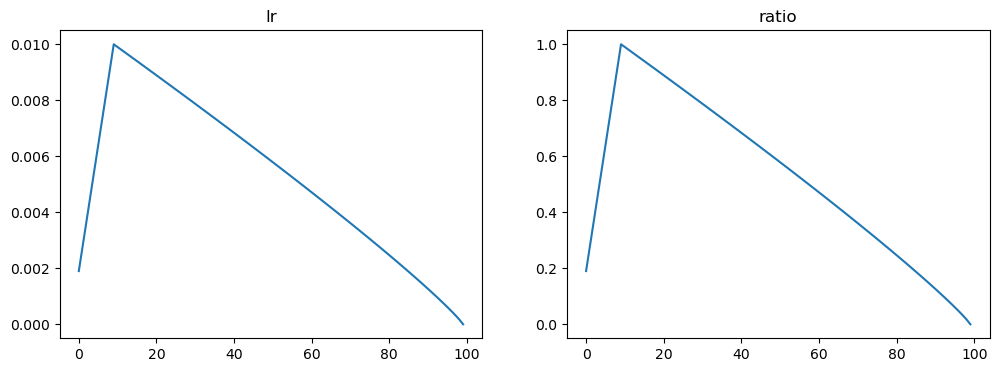

In [158]:
plot_lr_scheduler(scheduler, epochs=num_epochs)

In [164]:
from typing import List
# make a custom scheduler with repeated warmup
from core.utils.schedulers import WarmupLR, WarmupPolyLR
from torch.optim.lr_scheduler import _LRScheduler
class RepeatedWarmupPolyLR(_LRScheduler):
    
    def __init__(self, optimizer, warmup_iter=10, warmup_ratio=0.1, warmup='exp', last_epoch=-1, max_iter=100, power=0.9, restart_warmup_epochs: List[int] = None) -> None:
        self.warmup_iter = warmup_iter
        self.warmup_ratio = warmup_ratio
        self.warmup = warmup
        
        self.max_iter = max_iter
        self.power = power
        
        self.restart_warmup_epochs = restart_warmup_epochs
        if restart_warmup_epochs is not None:
            assert len(restart_warmup_epochs) > 0, 'restart_warmup_epochs should be a list of epochs'
            self.restart_warmup_epochs.sort()
            assert self.restart_warmup_epochs[0] >= self.warmup_iter, 'restart_warmup_epochs should be greater than warmup_iter'
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        ratio = self.get_lr_ratio()
        return [ratio * lr for lr in self.base_lrs]

    def get_lr_ratio(self):
        # return self.get_warmup_ratio() if self.last_epoch < self.warmup_iter else self.get_main_ratio()
        if self.last_epoch < self.warmup_iter:
            return self.get_warmup_ratio()
        else:
            if self.restart_warmup_epochs is not None:
                if self.last_epoch in self.restart_warmup_epochs:
                    current_epoch = self.last_epoch
                    self.last_epoch = -1
                    self.restart_warmup_epochs.pop(0)   
                    self.restart_warmup_epochs = [epoch - current_epoch for epoch in self.restart_warmup_epochs]
                    self.restart_warmup_epochs = [epoch for epoch in self.restart_warmup_epochs if epoch > 0]
                    
                    print(f'warmup iter is set to: {self.warmup_iter}, restart_warmup_epochs: {self.restart_warmup_epochs}')
                    
                    return self.get_warmup_ratio()
            return self.get_main_ratio()
    def get_main_ratio(self):
        real_iter = self.last_epoch - self.warmup_iter
        real_max_iter = self.max_iter - self.warmup_iter
        alpha = real_iter / real_max_iter
        ratio = (1 - alpha) ** self.power
        return ratio

    def get_warmup_ratio(self):
        assert self.warmup in ['linear', 'exp']
        alpha = self.last_epoch / self.warmup_iter
        
        ratio = self.warmup_ratio + (
                1. - self.warmup_ratio) * alpha if self.warmup == 'linear' else self.warmup_ratio ** (1. - alpha)
        return ratio

In [165]:
scheduler = RepeatedWarmupPolyLR(optimizer, max_iter=num_epochs, restart_warmup_epochs=None, warmup_iter=10)

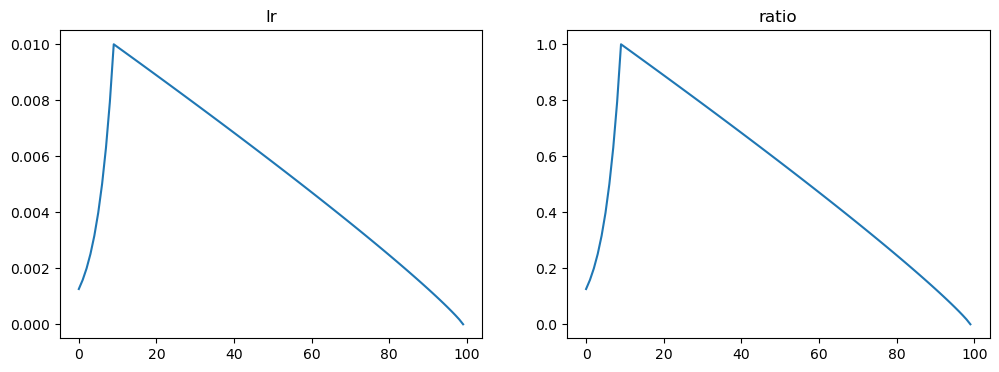

In [166]:
plot_lr_scheduler(scheduler, epochs=num_epochs)

warmup iter is set to: 10, restart_warmup_epochs: []


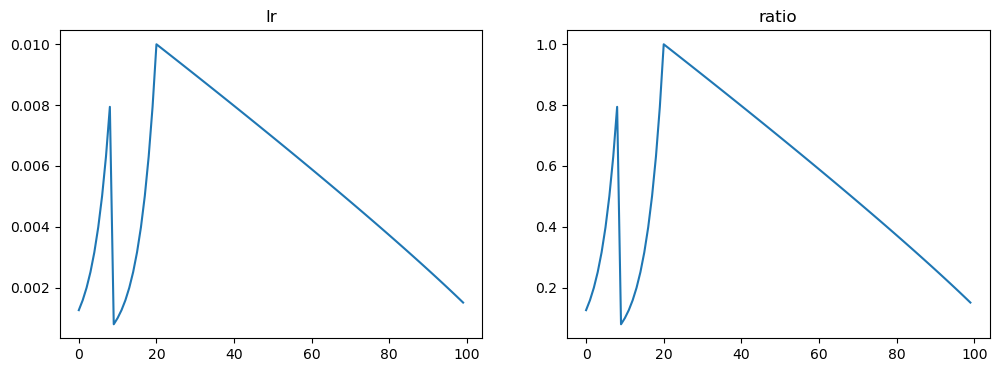

In [168]:
scheduler = RepeatedWarmupPolyLR(optimizer, max_iter=num_epochs, warmup_iter=10, restart_warmup_epochs=[10])
plot_lr_scheduler(scheduler, epochs=num_epochs)


In [139]:
|